In [1]:
import tensorflow as tf
from tensorflow.contrib import slim
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import os

In [2]:
BATCH_SIZE = 512
LR_PRIMAL = 2e-5
LR_DUAL = 1e-4

In [3]:
def get_data_samples(N):
    data = tf.random_uniform([N], minval=0, maxval=4, dtype=tf.int32)
    return data

def encoder_func(x, eps):
    net = tf.concat([x, eps], axis=-1)
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)

    z = slim.fully_connected(net, 2, activation_fn=None)

    return z


def decoder_func(z):
    net = z
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)
    net = slim.fully_connected(net, 64, activation_fn=tf.nn.elu)

    xlogits = slim.fully_connected(net, 4, activation_fn=None)
    return xlogits

# def discriminator_func(x, z):
#     netx, netz = x, z
#     netx =  slim.fully_connected(netx, 512, activation_fn=tf.nn.elu)
#     netx =  slim.fully_connected(netx, 512, activation_fn=tf.nn.elu)
#     netx =  slim.fully_connected(netx, 512, activation_fn=None)
    
#     netz =  slim.fully_connected(netz, 512, activation_fn=tf.nn.elu)
#     netz =  slim.fully_connected(netz, 512, activation_fn=tf.nn.elu)
#     netz =  slim.fully_connected(netz, 512, activation_fn=None)
    
#     net = tf.reduce_sum(netx * netz, axis=1)
# #     net += tf.reduce_sum(tf.square(z), axis=1)
    
#     return net

def discriminator_func(x, z):
    net = tf.concat([x, z], axis=1)
    net =  slim.fully_connected(net, 256, activation_fn=tf.nn.elu)
    for i in range(5):
        dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
        net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                    weights_initializer=tf.constant_initializer(0.))
        net = tf.nn.elu(net) 

#     net =  slim.fully_connected(net, 512, activation_fn=tf.nn.elu)
    net =  slim.fully_connected(net, 1, activation_fn=None)
    net = tf.squeeze(net, axis=1)
    net += tf.reduce_sum(tf.square(z), axis=1)
    
    return net

def create_scatter(x_test_labels, eps_test, savepath=None):
    plt.figure(figsize=(5,5), facecolor='w')

    for i in range(4):
        z_out = sess.run(z_inferred, feed_dict={x_real_labels: x_test_labels[i], eps: eps_test})
        plt.scatter(z_out[:, 0], z_out[:, 1],  edgecolor='none', alpha=0.5)

    plt.xlim(-3, 3); plt.ylim(-3.5, 3.5)

    plt.axis('off')
    if savepath:
        plt.savefig(savepath)

encoder = tf.make_template('encoder', encoder_func)
decoder = tf.make_template('decoder', decoder_func)
discriminator = tf.make_template('discriminator', discriminator_func)

In [4]:
eps = tf.random_normal([BATCH_SIZE, 64])
x_real_labels = get_data_samples(BATCH_SIZE)
x_real = tf.one_hot(x_real_labels, 4)
z_sampled = tf.random_normal([BATCH_SIZE, 2])
z_inferred = encoder(x_real, eps)
x_reconstr_logits = decoder(z_inferred)

Tjoint = discriminator(x_real, z_inferred)
Tseperate = discriminator(x_real, z_sampled)

reconstr_err = tf.reduce_sum(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=x_real, logits=x_reconstr_logits),
    axis=1
)

loss_primal = tf.reduce_mean(reconstr_err + Tjoint)
loss_dual = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Tjoint, labels=tf.ones_like(Tjoint))
    + tf.nn.sigmoid_cross_entropy_with_logits(logits=Tseperate, labels=tf.zeros_like(Tseperate))
)

optimizer_primal = tf.train.AdamOptimizer(LR_PRIMAL)
optimizer_dual = tf.train.AdamOptimizer(LR_DUAL)

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

train_op_primal = optimizer_primal.minimize(loss_primal, var_list=pvars+qvars)
train_op_dual = optimizer_dual.minimize(loss_dual, var_list=dvars)

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
x_test_labels = [[i] * BATCH_SIZE for i in range(4)]
eps_test = np.random.randn(BATCH_SIZE, 64) 

outdir = './out2_toy'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
progress = tqdm_notebook(range(100000))
for i in progress:
    ELBO_out, _ = sess.run([loss_primal, train_op_primal])
    sess.run(train_op_dual)
    sess.run(train_op_dual)

    progress.set_description('ELBO = %.2f' % ELBO_out)
    if i % 100 == 0:
        create_scatter(x_test_labels, eps_test, savepath=os.path.join(outdir, '%08d.png' % i))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/is/ps2/lmescheder/Apps/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
x_test_labels = [[i] * BATCH_SIZE for i in range(4)]
create_scatter(x_test_labels)
plt.show()


In [33]:
plt.figure(figsize=(5,5), facecolor='w')

z_out = np.random.randn(2048, 2)
plt.scatter(z_out[:, 0], z_out[:, 1],  edgecolor='none', alpha=0.5)

plt.xlim(-3, 3); plt.ylim(-3, 3)

plt.axis('off')
plt.savefig('out.png')

/is/ps2/lmescheder/Apps/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [37]:
plt.figure(figsize=(5,5), facecolor='w')

z_out = np.random.randn(2048,2)
z_out2 = z_out.copy()
z_out2[:, 0] =  0.5 * z_out[:, 1]**2 + 0.5 * z_out[:, 0] - 1
z_out2[:, 1] =  z_out[:, 1]

plt.scatter(z_out2[:, 0], z_out2[:, 1],  edgecolor='none', alpha=0.5)

plt.xlim(-3, 3); plt.ylim(-3, 3)

plt.axis('off')
plt.savefig('out2.png')

/is/ps2/lmescheder/Apps/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [54]:
plt.figure(figsize=(5,5), facecolor='w')

z_out = np.random.randn(512,2)
z_out2 = z_out.copy()
z_out2[:, 0] =  0.8 * np.cos(z_out[:, 1])**2 + 0.5 * z_out[:, 0] - 1
z_out2[:, 1] =  z_out[:, 1]
z_out2 = 0.5 * z_out2 + 0.5

plt.scatter(z_out2[:, 0], z_out2[:, 1],  edgecolor='none', alpha=0.5, color='orange')

plt.xlim(-3, 3); plt.ylim(-3, 3)

plt.axis('off')
plt.savefig('target.png')

/is/ps2/lmescheder/Apps/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [57]:
plt.figure(figsize=(5,5), facecolor='w')

mean, std = z_out2.mean(axis=0).reshape(1, -1), z_out2.std(axis=0).reshape(1, -1)
z_out = std*np.random.randn(512, 2) + mean
plt.scatter(z_out[:, 0], z_out[:, 1],  edgecolor='none', alpha=0.5)

plt.xlim(-3, 3); plt.ylim(-3, 3)

plt.axis('off')
plt.savefig('ac.png')

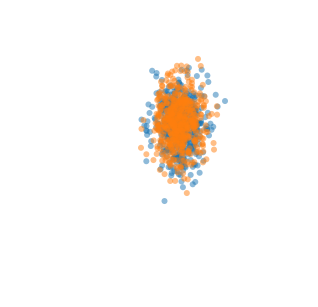

In [60]:
z_out = std*np.random.randn(512, 2) + mean
plt.scatter(z_out[:, 0], z_out[:, 1],  edgecolor='none', alpha=0.5)

plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.show()